<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Endpoints300s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [120]:
dataset_e1 = load_dataset("anastasiafrosted/endpoint0_120", download_mode="force_redownload")
dataset_e2 = load_dataset("anastasiafrosted/endpoint1_120", download_mode="force_redownload")

df_1 = pd.DataFrame(dataset_e1['train'])
df_2 = pd.DataFrame(dataset_e2['train'])

# Ensure the `timestamp` column is in datetime format
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'])

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/63019 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/601k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/53726 [00:00<?, ? examples/s]

In [121]:
data1 = df_1
data1 = data1.set_index("timestamp")
data2 = df_2
data2 = data2.set_index("timestamp")
freq='120s'

In [122]:
origin = "2023-06-15"
start = "2023-07-02" # origin + prediction_lenght
end = "2023-07-08"

train_data1 = data1["2022-12-20":origin]
valid_data1 = data1[origin:start]
test_data1 = data1[start:]

train_data2 = data2["2022-12-20":origin]
valid_data2 = data2[origin:start]
test_data2 = data2[start:]

# List of columns to drop
columns_to_drop = [
    'e_type_LSFProvider', 'e_type_CobaltProvider',
    'e_type_PBSProProvider', 'e_type_LocalProvider',
    'e_type_KubernetesProvider', 'e_type_SlurmProvider'
]
train_data1 = train_data1.drop(columns=columns_to_drop, errors='ignore')
valid_data1 = valid_data1.drop(columns=columns_to_drop, errors='ignore')
test_data1 = test_data1.drop(columns=columns_to_drop, errors='ignore')

train_data2 = train_data2.drop(columns=columns_to_drop, errors='ignore')
valid_data2 = valid_data2.drop(columns=columns_to_drop, errors='ignore')
test_data2 = test_data2.drop(columns=columns_to_drop, errors='ignore')

#### Scaling

In [123]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

In [124]:
# ENDPOINT 1:

# ZERO-FITTING

# Creare il range completo con frequenza al secondo
start_date = train_data1.index.min()
end_date = train_data1.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_train1 = train_data1.copy()
zero_fitted_train1 = zero_fitted_train1.reindex(time_period)
zero_fitted_train1 = zero_fitted_train1.fillna(0)
zero_fitted_train1.reset_index(inplace=True)
zero_fitted_train1.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_train1.set_index('timestamp', inplace=True)

# Creare il range completo con frequenza al secondo
start_date = valid_data1.index.min()
end_date = valid_data1.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_valid1 = valid_data1.copy()
zero_fitted_valid1 = zero_fitted_valid1.reindex(time_period)
zero_fitted_valid1 = zero_fitted_valid1.fillna(0)
zero_fitted_valid1.reset_index(inplace=True)
zero_fitted_valid1.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_valid1.set_index('timestamp', inplace=True)

# Creare il range completo con frequenza al secondo
start_date = test_data1.index.min()
end_date = test_data1.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_test1 = test_data1.copy()
zero_fitted_test1 = zero_fitted_test1.reindex(time_period)
zero_fitted_test1 = zero_fitted_test1.fillna(0)
zero_fitted_test1.reset_index(inplace=True)
zero_fitted_test1.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_test1.set_index('timestamp', inplace=True)

In [125]:
# ENDPOINT 1:

# SCALING
scaled_train1 = zero_fitted_train1.copy()
scaled_train1[scaled_train1.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    scaled_train1[scaled_train1.columns.drop('avg_invocations_rate')]
)
train1 = scaled_train1

# Per il dataset di validazione
scaled_valid1 = zero_fitted_valid1.copy()
scaled_valid1[scaled_valid1.columns.drop('avg_invocations_rate')] = scaler.transform(
    scaled_valid1[scaled_valid1.columns.drop('avg_invocations_rate')]
)
valid1 = scaled_valid1

# Per il dataset di test
scaled_test1 = zero_fitted_test1.copy()
scaled_test1[scaled_test1.columns.drop('avg_invocations_rate')] = scaler.transform(
    zero_fitted_test1[zero_fitted_test1.columns.drop('avg_invocations_rate')]
)
test1 = scaled_test1

In [126]:
# ENDPOINT 2:

# ZERO-FITTING

# Creare il range completo con frequenza al secondo
start_date = train_data2.index.min()
end_date = train_data2.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_train2 = train_data2.copy()
zero_fitted_train2 = zero_fitted_train2.reindex(time_period)
zero_fitted_train2 = zero_fitted_train2.fillna(0)
zero_fitted_train2.reset_index(inplace=True)
zero_fitted_train2.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_train2.set_index('timestamp', inplace=True)

# Creare il range completo con frequenza al secondo
start_date = valid_data2.index.min()
end_date = valid_data2.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_valid2 = valid_data2.copy()
zero_fitted_valid2 = zero_fitted_valid2.reindex(time_period)
zero_fitted_valid2 = zero_fitted_valid2.fillna(0)
zero_fitted_valid2.reset_index(inplace=True)
zero_fitted_valid2.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_valid2.set_index('timestamp', inplace=True)

# Creare il range completo con frequenza al secondo
start_date = test_data2.index.min()
end_date = test_data2.index.max()
time_period = pd.date_range(start=start_date, end=end_date, freq=freq)
zero_fitted_test2 = test_data2.copy()
zero_fitted_test2 = zero_fitted_test2.reindex(time_period)
zero_fitted_test2 = zero_fitted_test2.fillna(0)
zero_fitted_test2.reset_index(inplace=True)
zero_fitted_test2.rename(columns={'index': 'timestamp'}, inplace=True)
zero_fitted_test2.set_index('timestamp', inplace=True)

In [127]:
# ENDPOINT 2:

# SCALING
scaled_train2 = zero_fitted_train2.copy()
scaled_train2[scaled_train2.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    scaled_train2[scaled_train2.columns.drop('avg_invocations_rate')]
)
train2 = scaled_train2

# Per il dataset di validazione
scaled_valid2 = zero_fitted_valid2.copy()
scaled_valid2[scaled_valid2.columns.drop('avg_invocations_rate')] = scaler.transform(
    scaled_valid2[scaled_valid2.columns.drop('avg_invocations_rate')]
)
valid2 = scaled_valid2

# Per il dataset di test
scaled_test2 = zero_fitted_test2.copy()
scaled_test2[scaled_test2.columns.drop('avg_invocations_rate')] = scaler.transform(
    zero_fitted_test2[zero_fitted_test2.columns.drop('avg_invocations_rate')]
)
test2 = scaled_test2

#### Config (Parameters)

In [164]:
batch_size = 1
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 32
epochs = 1

# Models

## Forecasting one-step-ahead

In [165]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [157]:
tr1 = train1['avg_invocations_rate']
vl1 = valid1['avg_invocations_rate']
ts1 = test1['avg_invocations_rate']

tr2 = train2['avg_invocations_rate']
vl2 = valid2['avg_invocations_rate']
ts2 = test2['avg_invocations_rate']

In [158]:
t = test1['avg_invocations_rate'].iloc[0]
print(t)

0.175


In [159]:
# ENDPOINT 1:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    tr1.to_numpy(),
    targets=tr1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    vl1.to_numpy(),
    targets=vl1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    ts1.to_numpy(),
    targets=ts1[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [161]:
# ENDPOINT 2:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    tr2.to_numpy(),
    targets=tr2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    vl2.to_numpy(),
    targets=vl2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    ts2.to_numpy(),
    targets=ts2[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [169]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [170]:
fit_and_evaluate(model, train_ds1, valid_ds1)

103782/103782 ━━━━━━━━━━━━━━━━━━━━ 180s 2ms/step - loss: 3.5116e-04 - mae: 0.0147 - val_loss: 1.0933e-04 - val_mae: 0.0072
12953/12953 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 9.8312e-05 - mae: 0.0070


7210.831623524427

773/773 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


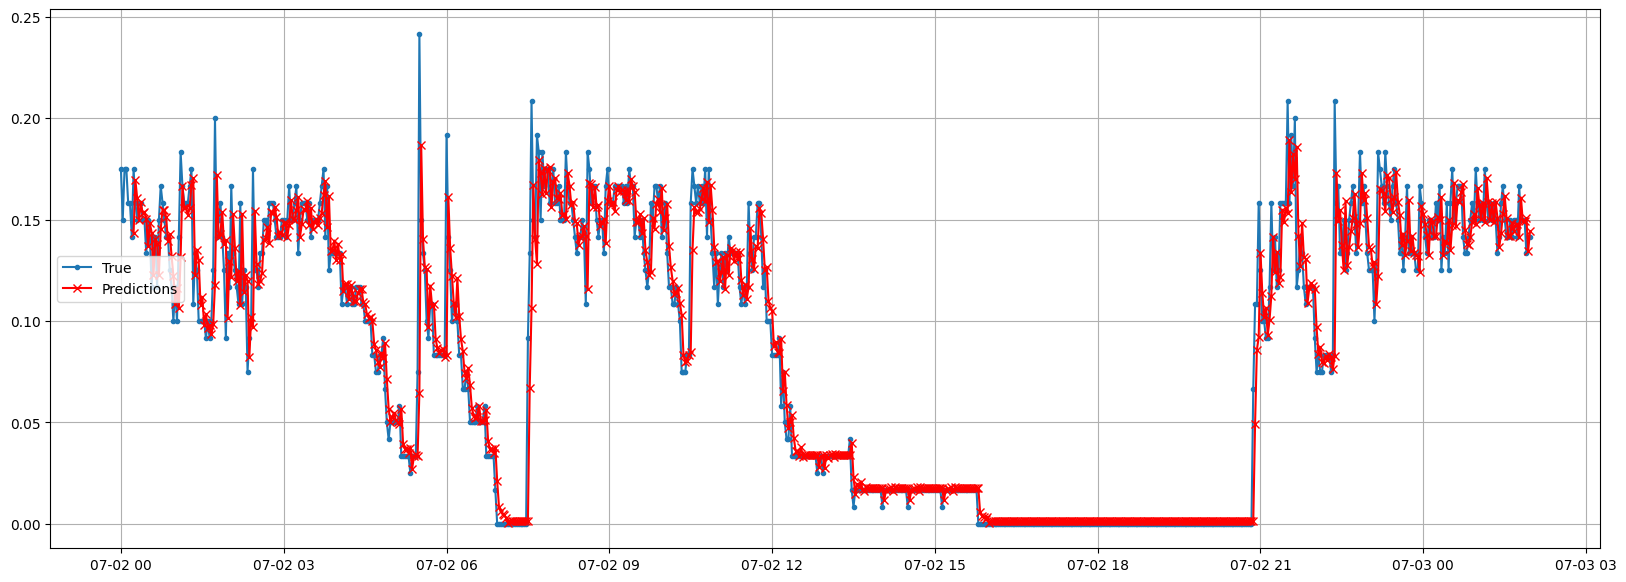

In [171]:
Y_pred = model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=test1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [176]:
fit_and_evaluate(model, train_ds2, valid_ds2)

104561/104561 ━━━━━━━━━━━━━━━━━━━━ 149s 1ms/step - loss: 5.5194e-05 - mae: 0.0038 - val_loss: 1.9480e-05 - val_mae: 0.0036
11878/11878 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 9.7316e-06 - mae: 0.0023


3611.1781373620033

773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


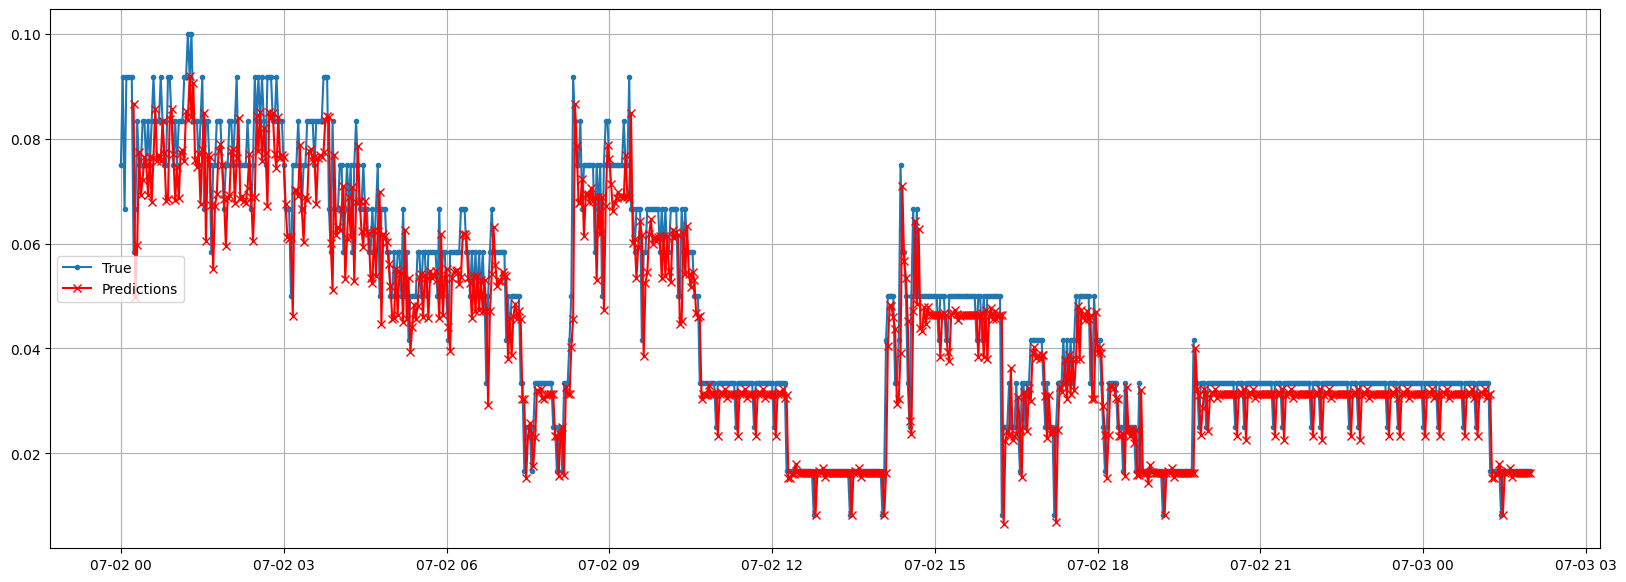

In [177]:
Y_pred = model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=test2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [55]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
fit_and_evaluate(univar_model, train_ds1, valid_ds1)

Epoch 1/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 3.7225e-04 - mae: 0.0157 - val_loss: 1.3190e-04 - val_mae: 0.0085
Epoch 2/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 1.7464e-04 - mae: 0.0099 - val_loss: 1.2048e-04 - val_mae: 0.0085
Epoch 3/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 1.6324e-04 - mae: 0.0094 - val_loss: 1.1450e-04 - val_mae: 0.0073
Epoch 4/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 1.5775e-04 - mae: 0.0091 - val_loss: 1.1333e-04 - val_mae: 0.0068
Epoch 5/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 1.5553e-04 - mae: 0.0090 - val_loss: 1.1060e-04 - val_mae: 0.0070
Epoch 6/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 1.5407e-04 - mae: 0.0089 - val_loss: 1.0952e-04 - val_mae: 0.0072
Epoch 7/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 1.5443e-04 - mae: 0.0091 - val_loss: 1.1170e-04 - val_mae: 0.0086
Epoch 8/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 1.5324e-04 - mae: 0.0089 - val_los

6832.586135715246

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


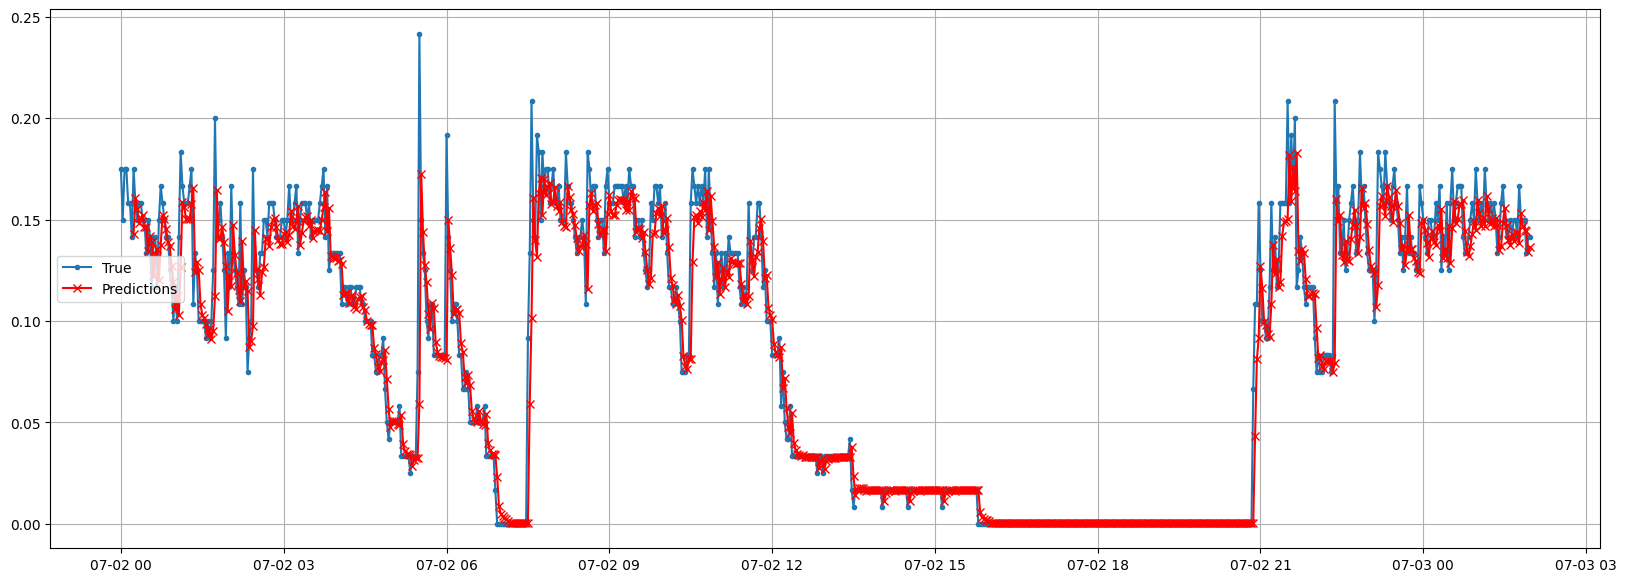

In [57]:
Y_pred = univar_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [58]:
fit_and_evaluate(univar_model, train_ds2, valid_ds2)

Epoch 1/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 6.0279e-05 - mae: 0.0035 - val_loss: 1.8007e-05 - val_mae: 0.0035
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - loss: 5.7098e-05 - mae: 0.0034 - val_loss: 1.6240e-05 - val_mae: 0.0034
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 5.5884e-05 - mae: 0.0035 - val_loss: 2.0095e-05 - val_mae: 0.0039
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 5.4982e-05 - mae: 0.0034 - val_loss: 2.0320e-05 - val_mae: 0.0040
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 5.4213e-05 - mae: 0.0034 - val_loss: 1.7615e-05 - val_mae: 0.0033
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 5.3683e-05 - mae: 0.0034 - val_loss: 1.7236e-05 - val_mae: 0.0033
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 5.3434e-05 - mae: 0.0033 - val_loss: 2.1432e-05 - val_mae: 0.0043
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 5.3313e-05 - mae: 0.0033 - val_los

3283.1693533807993

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


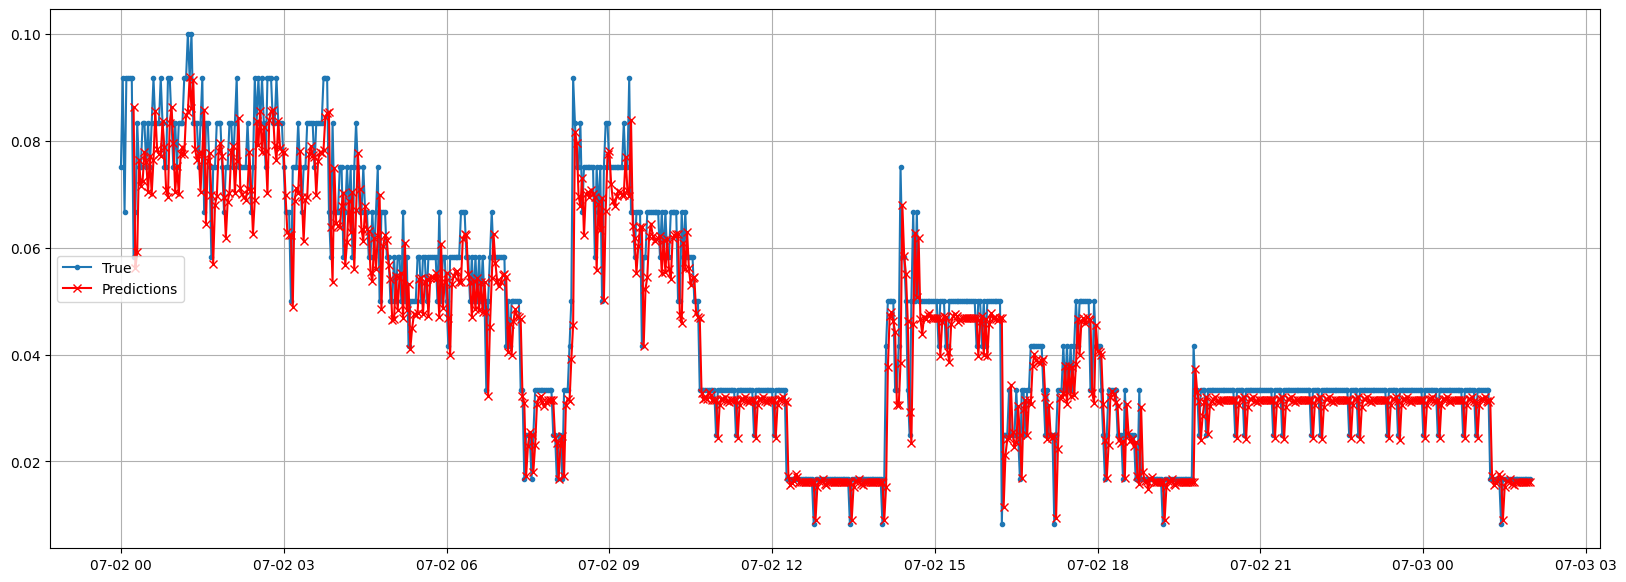

In [59]:
Y_pred = univar_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Deep RNN

In [166]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [167]:
fit_and_evaluate(deep_model, train_ds1, valid_ds1)

103782/103782 ━━━━━━━━━━━━━━━━━━━━ 712s 7ms/step - loss: 5.3712e-04 - mae: 0.0198 - val_loss: 1.4599e-04 - val_mae: 0.0115
12953/12953 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 1.3206e-04 - mae: 0.0111


11467.525735497475

773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


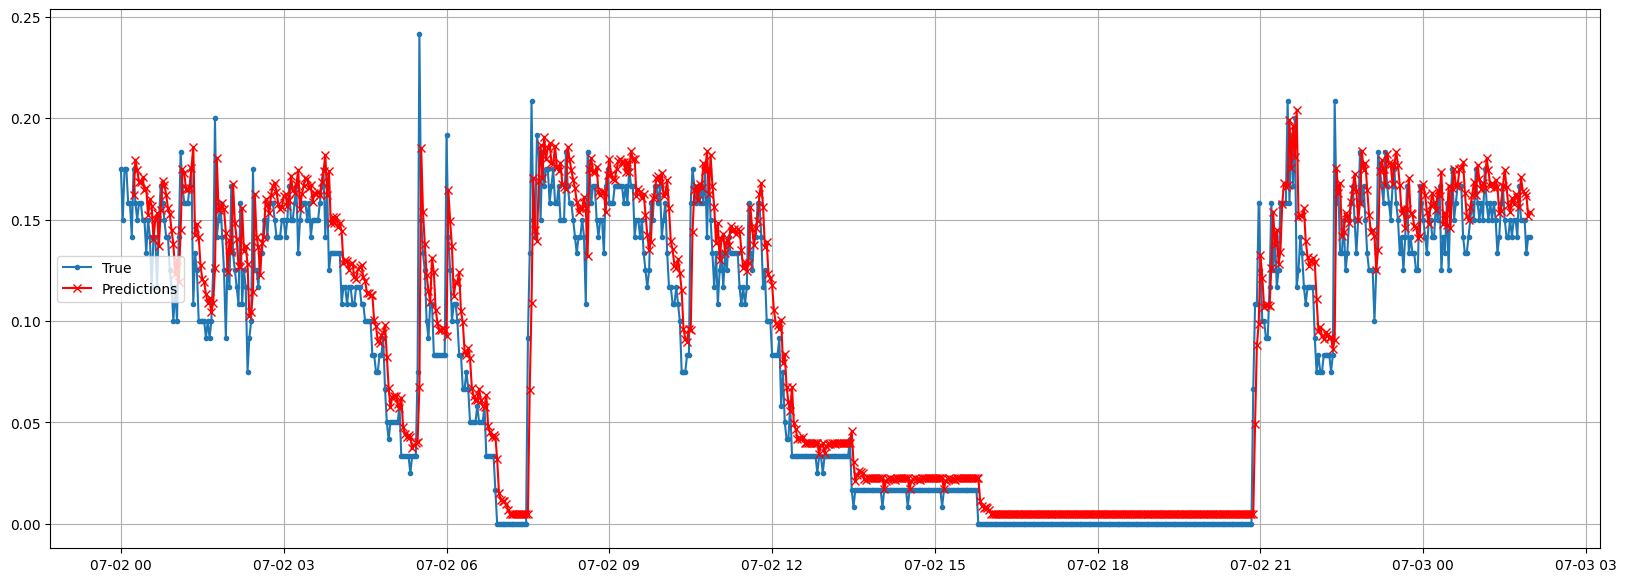

In [168]:
Y_pred = deep_model.predict(test_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [181]:
new_value = np.array([[0.015]]).reshape(1, 1, 1)
prediction = deep_model.predict(new_value)
print(f'Predizione: {prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predizione: [[0.115]]


In [138]:
import joblib

# Assuming `model` is your trained model
joblib.dump(deep_model, 'model1.pkl')

['model1.pkl']

In [ ]:
print(test_ds1)
for sample in test_ds1.take(1):
    print(sample)  # Controlla se il formato è corretto
    break

for sample in test_ds1.take(1):
    single_sample = sample[0].numpy().reshape(1, -1)  # Prende solo la prima riga e la trasforma in forma corretta
    break

In [152]:
m = joblib.load('model1.pkl')
y = m.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step


In [153]:
print(y)

[[0.132]
 [0.158]
 [0.149]
 [0.138]
 [0.148]
 [0.146]
 [0.138]
 [0.139]
 [0.124]
 [0.137]
 [0.133]
 [0.108]
 [0.13 ]
 [0.133]
 [0.108]
 [0.138]
 [0.157]
 [0.146]
 [0.141]
 [0.132]
 [0.129]
 [0.116]
 [0.108]
 [0.094]
 [0.107]
 [0.095]
 [0.129]
 [0.173]
 [0.158]
 [0.148]
 [0.147]
 [0.142]]


In [139]:
fit_and_evaluate(deep_model, train_ds2, valid_ds2)

Epoch 1/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 49s 14ms/step - loss: 5.5619e-05 - mae: 0.0041 - val_loss: 2.1567e-05 - val_mae: 0.0045
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - loss: 5.4999e-05 - mae: 0.0041 - val_loss: 1.8886e-05 - val_mae: 0.0045
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 5.4465e-05 - mae: 0.0040 - val_loss: 2.1460e-05 - val_mae: 0.0051
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 5.5840e-05 - mae: 0.0043 - val_loss: 1.7001e-05 - val_mae: 0.0037
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - loss: 5.4599e-05 - mae: 0.0041 - val_loss: 2.8002e-05 - val_mae: 0.0064
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 5.4285e-05 - mae: 0.0041 - val_loss: 2.0465e-05 - val_mae: 0.0041
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 5.4375e-05 - mae: 0.0041 - val_loss: 1.9789e-05 - val_mae: 0.0041
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 5.5005e-05 - mae: 0.0043 -

3164.601046591997

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


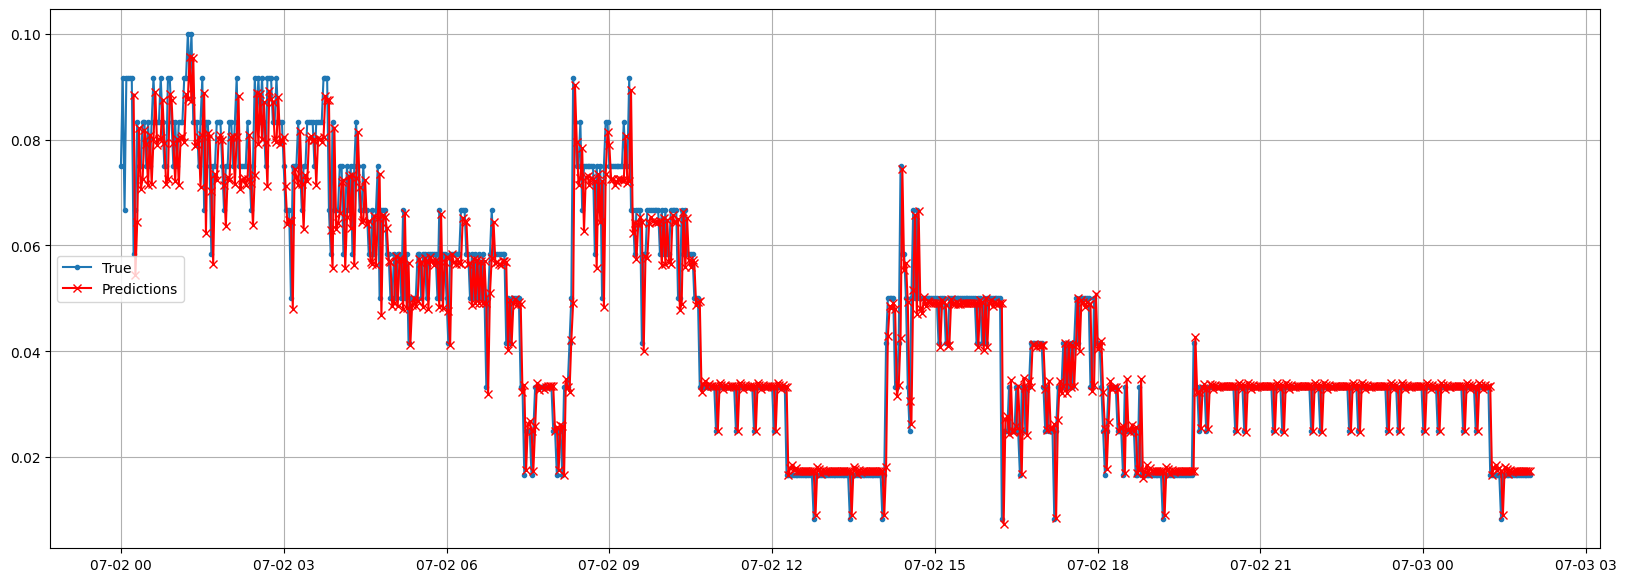

In [140]:
Y_pred = deep_model.predict(test_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [141]:
import joblib

# Assuming `model` is your trained model
joblib.dump(deep_model, 'model2.pkl')

['model2.pkl']

### Multivariate Series

In [65]:
# ENDPOINT 1:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=train1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=valid1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=test1['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

In [66]:
# ENDPOINT 2:

tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=train2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=valid2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=test2['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [67]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
fit_and_evaluate(mulvar_model, train_mulvar_ds1, valid_mulvar_ds1)

Epoch 1/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 0.0068 - mae: 0.0404 - val_loss: 2.2654e-04 - val_mae: 0.0119
Epoch 2/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 2.4632e-04 - mae: 0.0118 - val_loss: 1.6849e-04 - val_mae: 0.0093
Epoch 3/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 2.0113e-04 - mae: 0.0107 - val_loss: 1.4215e-04 - val_mae: 0.0087
Epoch 4/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - loss: 1.8216e-04 - mae: 0.0101 - val_loss: 1.3799e-04 - val_mae: 0.0092
Epoch 5/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 1.7307e-04 - mae: 0.0099 - val_loss: 1.2652e-04 - val_mae: 0.0081
Epoch 6/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 1.6800e-04 - mae: 0.0099 - val_loss: 1.1926e-04 - val_mae: 0.0073
Epoch 7/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 1.6394e-04 - mae: 0.0097 - val_loss: 1.1663e-04 - val_mae: 0.0075
Epoch 8/10
3244/3244 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 1.5946e-04 - mae: 0.0096 - val_loss: 1

7030.912209302187

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


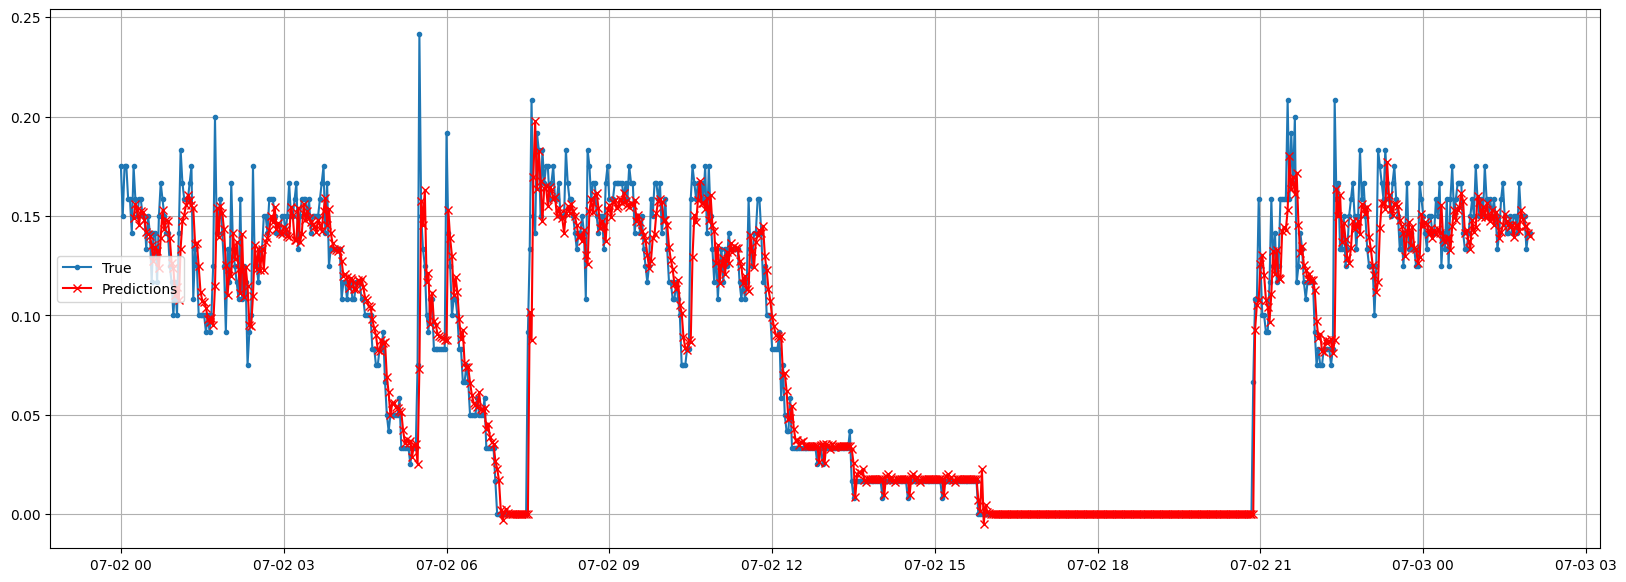

In [69]:
Y_pred = mulvar_model.predict(test_mulvar_ds1)
Y_pred = pd.Series(Y_pred.flatten(), index=ts1.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test1['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

In [70]:
fit_and_evaluate(mulvar_model, train_mulvar_ds2, valid_mulvar_ds2)

Epoch 1/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - loss: 3.1774e-04 - mae: 0.0093 - val_loss: 1.0392e-04 - val_mae: 0.0073
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 1.0766e-04 - mae: 0.0056 - val_loss: 6.4289e-05 - val_mae: 0.0055
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 8.5769e-05 - mae: 0.0049 - val_loss: 5.6064e-05 - val_mae: 0.0056
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - loss: 7.4465e-05 - mae: 0.0045 - val_loss: 5.7710e-05 - val_mae: 0.0051
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 6.7169e-05 - mae: 0.0043 - val_loss: 4.9496e-05 - val_mae: 0.0050
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 6.2053e-05 - mae: 0.0040 - val_loss: 4.1891e-05 - val_mae: 0.0048
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 5.8885e-05 - mae: 0.0039 - val_loss: 4.3626e-05 - val_mae: 0.0050
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - loss: 5.6162e-05 - mae: 0.0038 - val_los

4354.469012469053

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


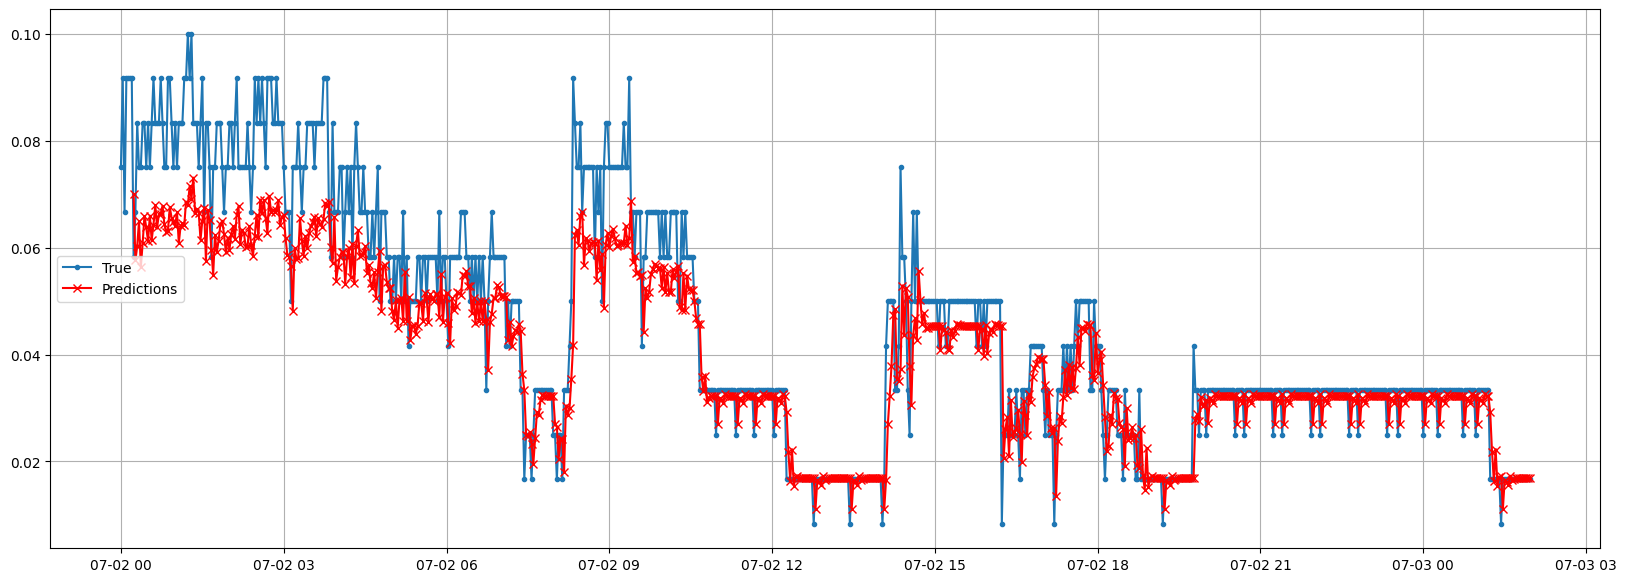

In [71]:
Y_pred = mulvar_model.predict(test_mulvar_ds2)
Y_pred = pd.Series(Y_pred.flatten(), index=ts2.index[sequence_lenght:])

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test2['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


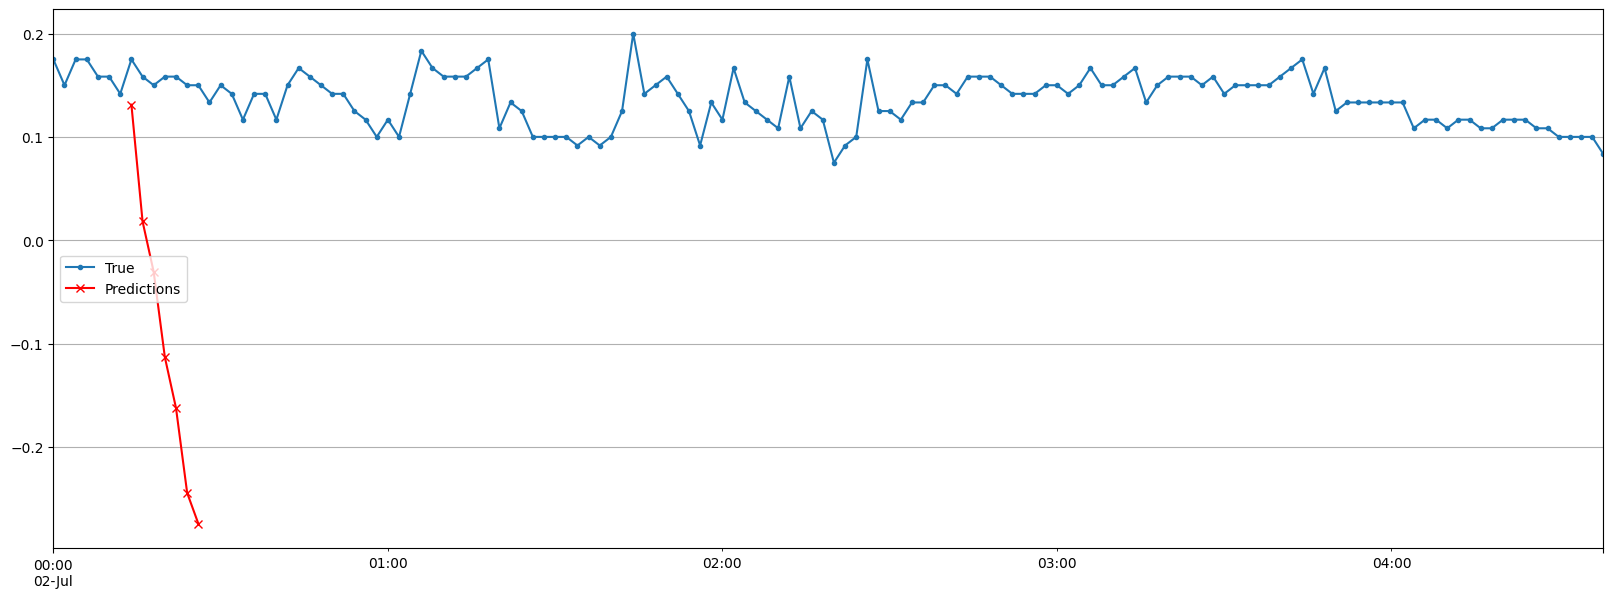

In [72]:
X = ts1[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts1.index[sequence_lenght], end=ts1.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1[:(sequence_lenght*20)])[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


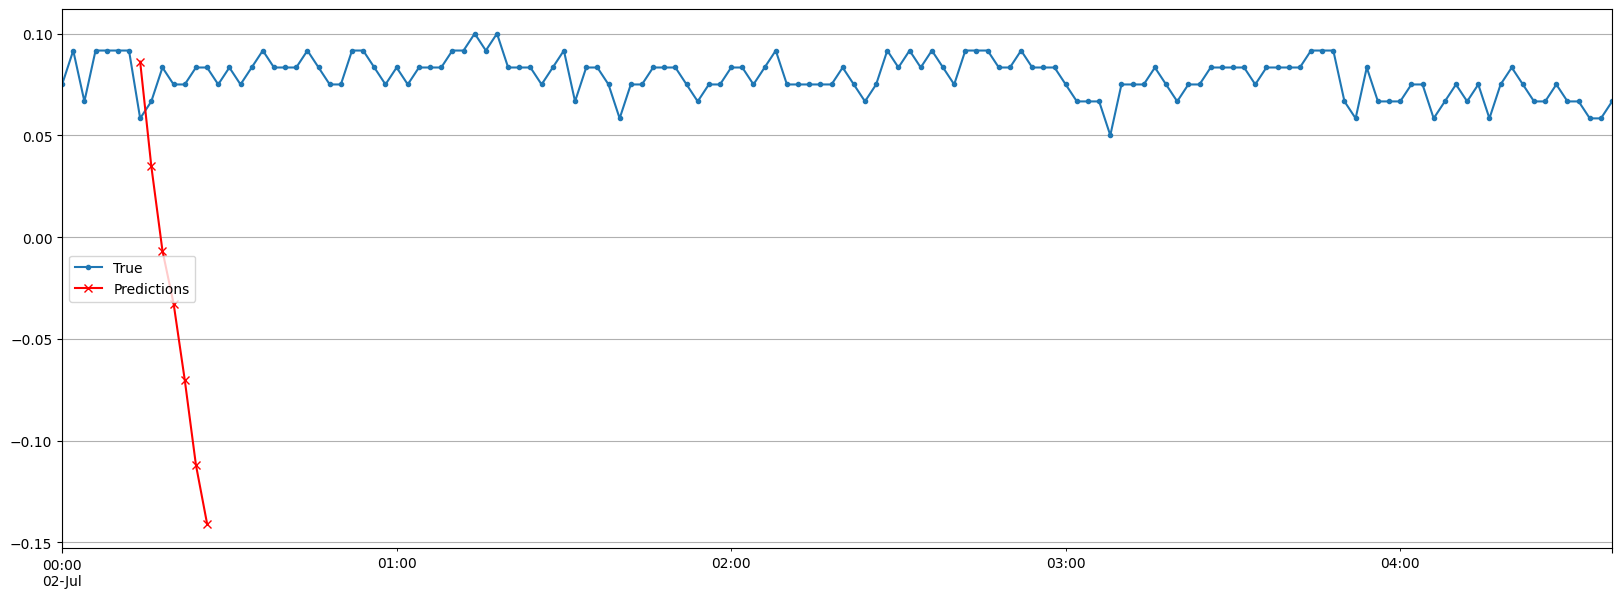

In [73]:
X = ts2[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts2.index[sequence_lenght], end=ts2.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2[:(sequence_lenght*20)]).plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### DeepRNN

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


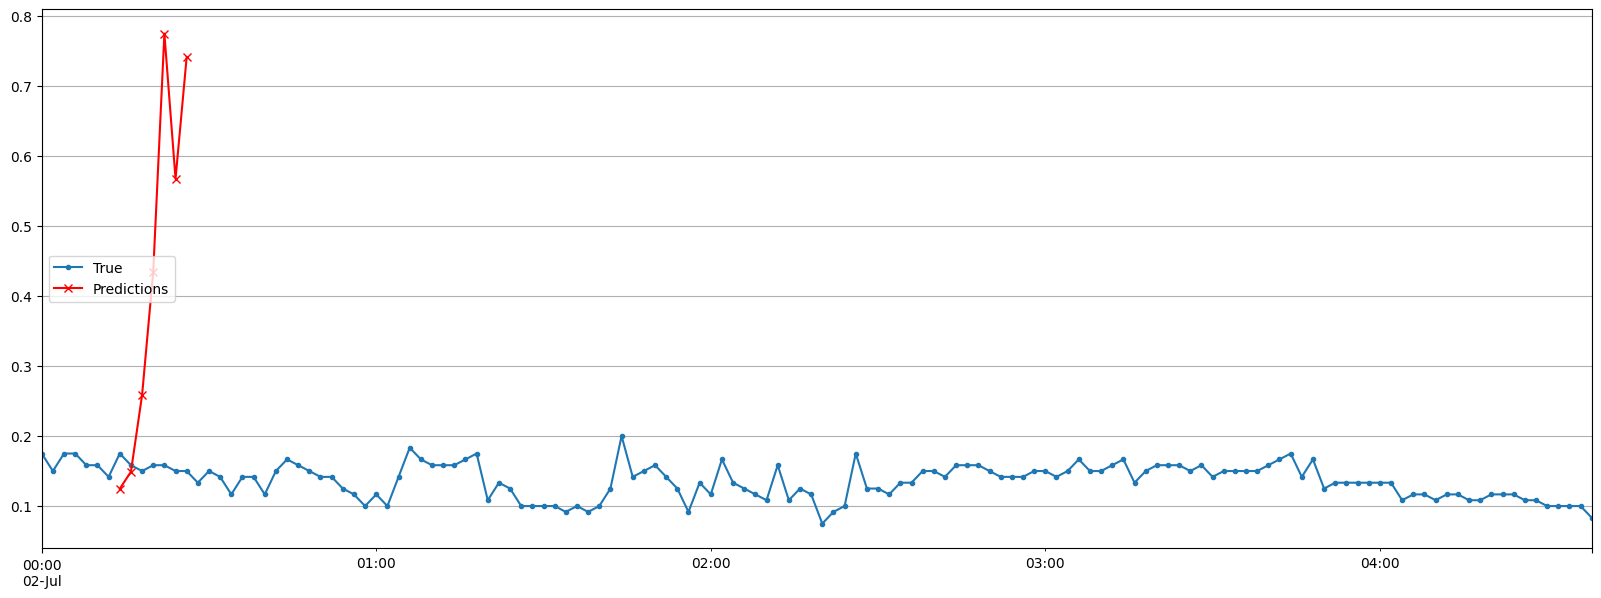

In [74]:
X = ts1.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
# run a for loop running multiple times the univar_model and extract the last prediction each time
# concatenate that to the data and keep predicting
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = deep_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts1.index[prediction_lenght], end=ts1.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1[:(sequence_lenght*20)])[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


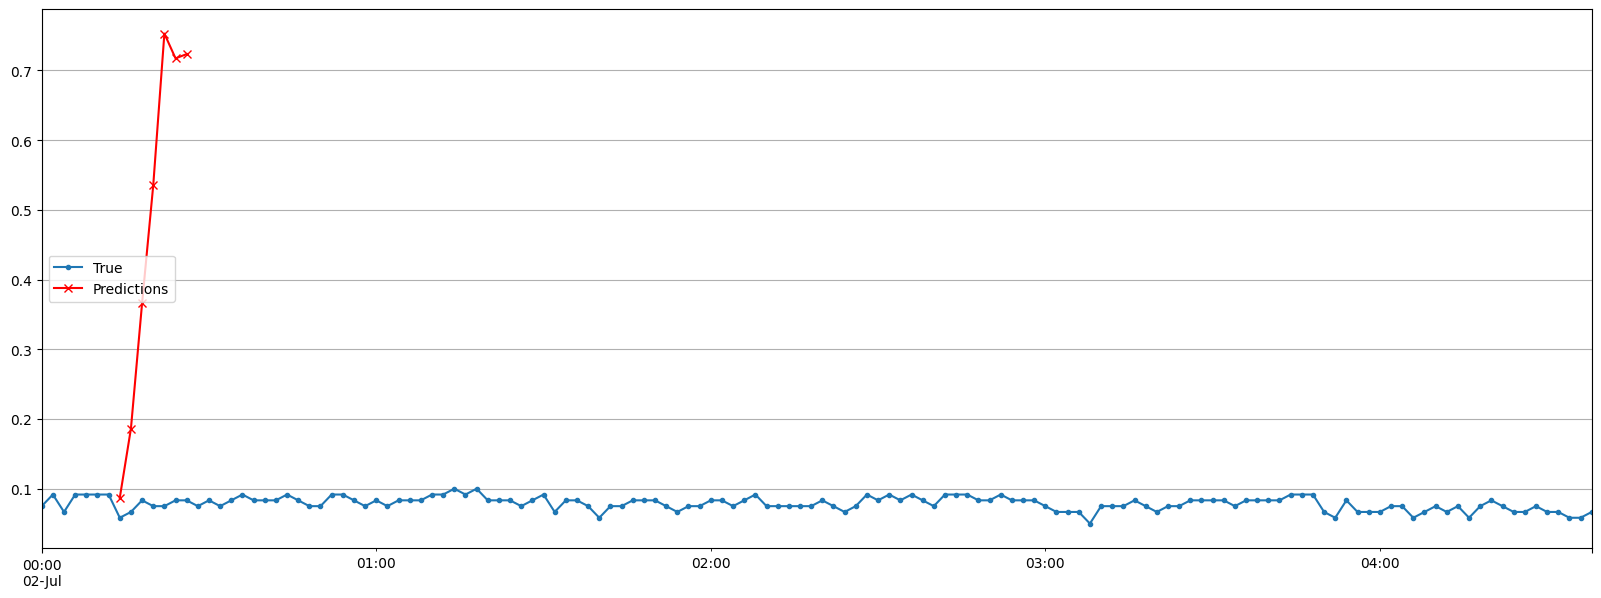

In [75]:
X = ts2.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
# run a for loop running multiple times the univar_model and extract the last prediction each time
# concatenate that to the data and keep predicting
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = deep_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts2.index[prediction_lenght], end=ts2.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2[:(sequence_lenght*20)])[start:start].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [76]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

In [77]:
# ENDPOINT 1:

ahead_train_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    train1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    valid1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds1 = tf.keras.utils.timeseries_dataset_from_array(
    test1,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [78]:
# ENDPOINT 2:

ahead_train_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    train2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    valid2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds2 = tf.keras.utils.timeseries_dataset_from_array(
    test2,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [79]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
fit_and_evaluate(ahead_model, ahead_train_ds1, ahead_valid_ds1)

Epoch 1/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0723 - mae: 0.1932 - val_loss: 0.0346 - val_mae: 0.1491
Epoch 2/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0541 - mae: 0.1549 - val_loss: 0.0327 - val_mae: 0.1264
Epoch 3/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0536 - mae: 0.1533 - val_loss: 0.0328 - val_mae: 0.1296
Epoch 4/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0533 - mae: 0.1527 - val_loss: 0.0326 - val_mae: 0.1251
Epoch 5/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.0530 - mae: 0.1518 - val_loss: 0.0321 - val_mae: 0.1168
Epoch 6/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0529 - mae: 0.1512 - val_loss: 0.0323 - val_mae: 0.1237
Epoch 7/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0527 - mae: 0.1509 - val_loss: 0.0329 - val_mae: 0.1346
Epoch 8/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0526 - mae: 0.1510 - val_loss: 0.0326 - val_mae: 0.1299
Epoch 9/10
3243/3243 ━━━━━━━━━━━

114343.82945299149

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


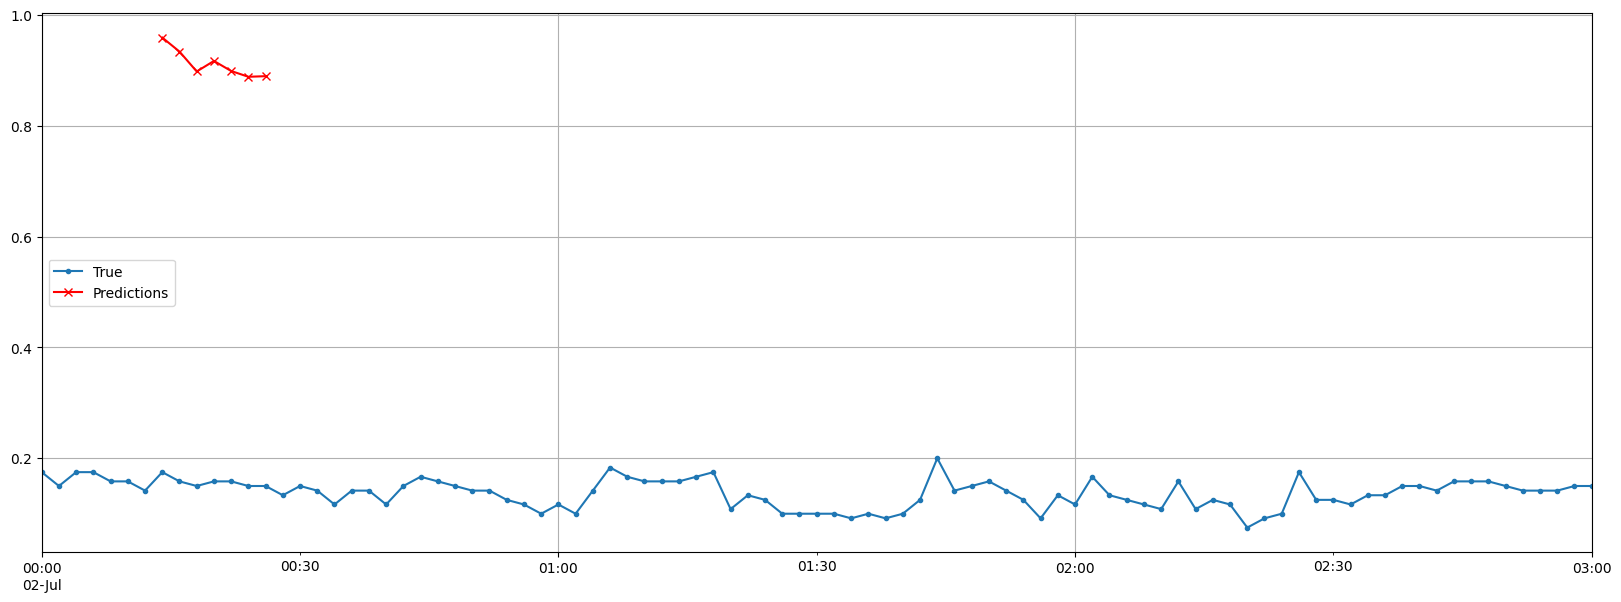

In [81]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)

Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts1.index[sequence_lenght], end=ts1.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
plt.show()

In [82]:
fit_and_evaluate(ahead_model, ahead_train_ds2, ahead_valid_ds2)

Epoch 1/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.0407 - mae: 0.1021 - val_loss: 0.0145 - val_mae: 0.0451
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0353 - mae: 0.0908 - val_loss: 0.0141 - val_mae: 0.0443
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0344 - mae: 0.0895 - val_loss: 0.0138 - val_mae: 0.0446
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0339 - mae: 0.0888 - val_loss: 0.0138 - val_mae: 0.0448
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0336 - mae: 0.0880 - val_loss: 0.0137 - val_mae: 0.0421
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0332 - mae: 0.0868 - val_loss: 0.0136 - val_mae: 0.0452
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0330 - mae: 0.0873 - val_loss: 0.0135 - val_mae: 0.0395
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0329 - mae: 0.0869 - val_loss: 0.0136 - val_mae: 0.0423
Epoch 9/10
3268/3268 ━━━━━━━━━━━

39488.404989242554

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


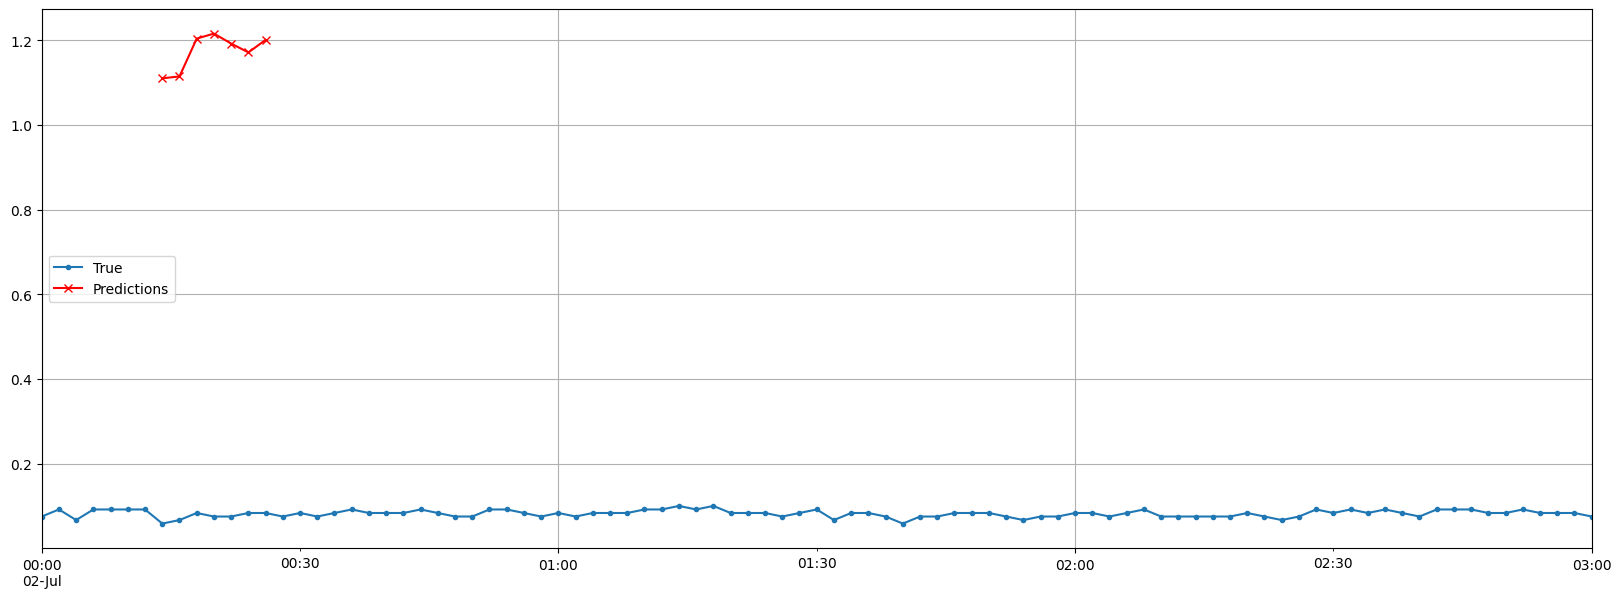

In [83]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts2.index[sequence_lenght], end=ts2.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [84]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [85]:
seq2seq_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght, ahead=prediction_lenght)

seq2seq_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [86]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [87]:
fit_and_evaluate(seq2seq_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
   3238/Unknown 33s 10ms/step - loss: 0.0749 - mae: 0.2019

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3243/3243 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0749 - mae: 0.2018 - val_loss: 0.0327 - val_mae: 0.1045
Epoch 2/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 0.0650 - mae: 0.1714 - val_loss: 0.0326 - val_mae: 0.1041
Epoch 3/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0646 - mae: 0.1703 - val_loss: 0.0324 - val_mae: 0.1028
Epoch 4/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0643 - mae: 0.1698 - val_loss: 0.0323 - val_mae: 0.1002
Epoch 5/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0641 - mae: 0.1693 - val_loss: 0.0321 - val_mae: 0.1010
Epoch 6/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.0638 - mae: 0.1687 - val_loss: 0.0319 - val_mae: 0.1057
Epoch 7/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0636 - mae: 0.1684 - val_loss: 0.0318 - val_mae: 0.1006
Epoch 8/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.0632 - mae: 0.1677 - val_loss: 0.0318 - val_mae: 0.1001
Epoch 9/10
3243/3243 ━━━━━━━━━━━━━━

100083.91737937927

In [88]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test1)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test1.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test1["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE for +1: 912,839
MAE for +2: 906,223
MAE for +3: 887,151
MAE for +4: 905,953
MAE for +5: 904,102
MAE for +6: 914,035
MAE for +7: 913,491


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


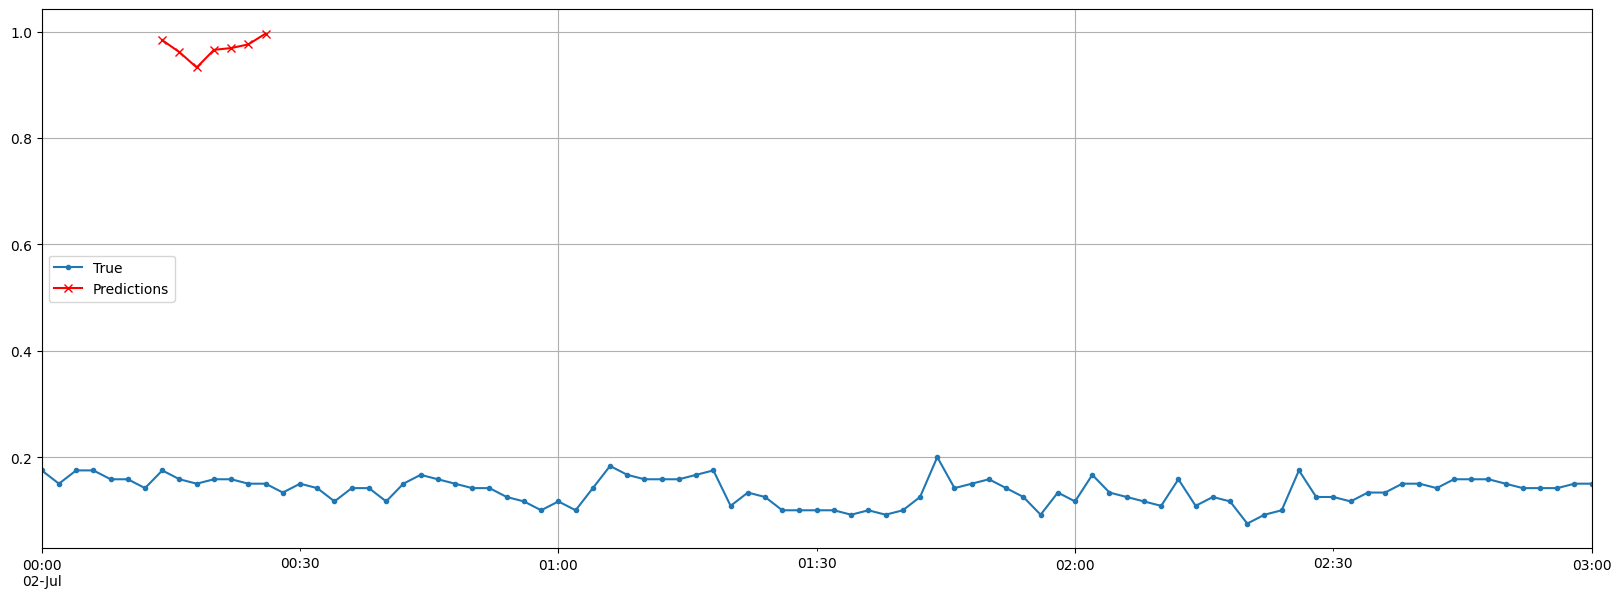

In [89]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[sequence_lenght], end=ts1.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [90]:
fit_and_evaluate(seq2seq_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
   3268/Unknown 34s 10ms/step - loss: 0.0675 - mae: 0.1607

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3268/3268 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.0674 - mae: 0.1607 - val_loss: 0.0146 - val_mae: 0.0511
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0655 - mae: 0.1558 - val_loss: 0.0142 - val_mae: 0.0494
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.0648 - mae: 0.1551 - val_loss: 0.0140 - val_mae: 0.0480
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.0646 - mae: 0.1545 - val_loss: 0.0138 - val_mae: 0.0461
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - loss: 0.0642 - mae: 0.1537 - val_loss: 0.0137 - val_mae: 0.0445
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0639 - mae: 0.1530 - val_loss: 0.0136 - val_mae: 0.0447
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.0636 - mae: 0.1521 - val_loss: 0.0136 - val_mae: 0.0439
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0632 - mae: 0.1511 - val_loss: 0.0135 - val_mae: 0.0448
Epoch 9/10
3268/3268 ━━━━━━━━━━━━━━

43877.486139535904

In [91]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test2)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test2.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test2["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
MAE for +1: 1,136,359
MAE for +2: 1,133,800
MAE for +3: 1,131,760
MAE for +4: 1,130,540
MAE for +5: 1,147,355
MAE for +6: 1,124,750
MAE for +7: 1,142,323


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


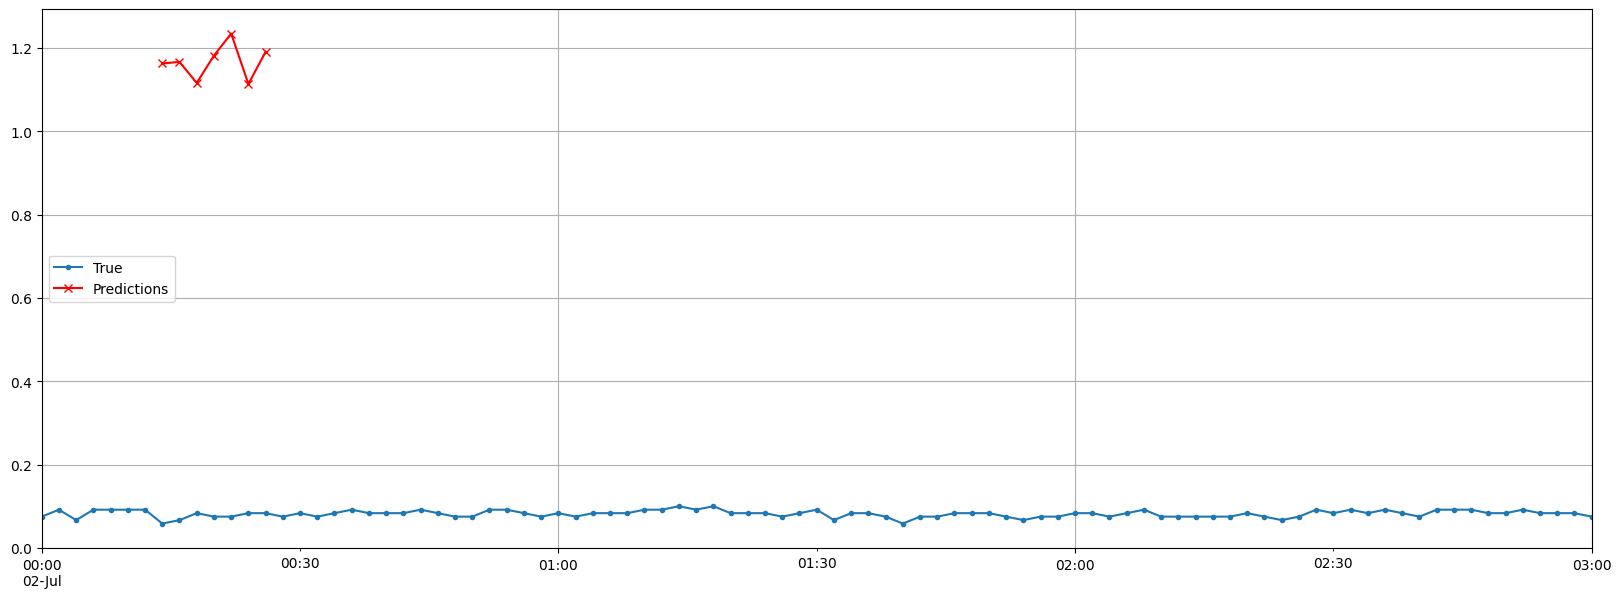

In [92]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[sequence_lenght], end=ts2.index[sequence_lenght+prediction_lenght-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)["2023-07-02 00:00":"2023-07-02 03:00"].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

# - FINO QUI -

#### RNN with layer normalization

In [93]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [94]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [95]:
fit_and_evaluate(custom_ln_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
   3234/Unknown 41s 12ms/step - loss: 0.0714 - mae: 0.1902

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3243/3243 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - loss: 0.0713 - mae: 0.1902 - val_loss: 0.0330 - val_mae: 0.1009
Epoch 2/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 0.0643 - mae: 0.1698 - val_loss: 0.0328 - val_mae: 0.1047
Epoch 3/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 78s 13ms/step - loss: 0.0639 - mae: 0.1689 - val_loss: 0.0326 - val_mae: 0.1050
Epoch 4/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0639 - mae: 0.1691 - val_loss: 0.0325 - val_mae: 0.1057
Epoch 5/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 0.0635 - mae: 0.1682 - val_loss: 0.0324 - val_mae: 0.1036
Epoch 6/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0633 - mae: 0.1681 - val_loss: 0.0323 - val_mae: 0.1023
Epoch 7/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 0.0632 - mae: 0.1678 - val_loss: 0.0321 - val_mae: 0.1023
Epoch 8/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0630 - mae: 0.1676 - val_loss: 0.0320 - val_mae: 0.1056
Epoch 9/10
3243/3243 ━━━━━━━━━━━━━━

99627.67362594604

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


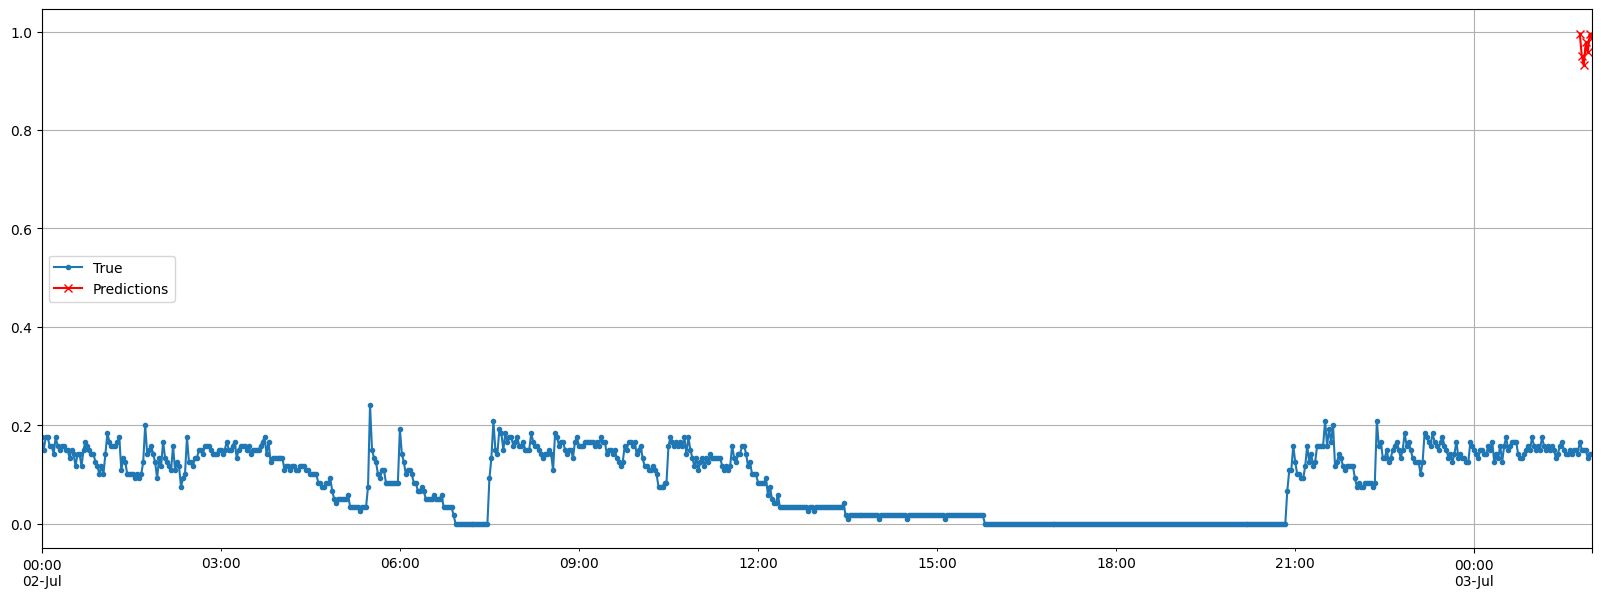

In [96]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [97]:
fit_and_evaluate(custom_ln_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
   3261/Unknown 42s 12ms/step - loss: 0.0656 - mae: 0.1588

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3268/3268 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - loss: 0.0656 - mae: 0.1587 - val_loss: 0.0166 - val_mae: 0.0688
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 0.0656 - mae: 0.1540 - val_loss: 0.0154 - val_mae: 0.0590
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0650 - mae: 0.1518 - val_loss: 0.0146 - val_mae: 0.0524
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 83s 13ms/step - loss: 0.0643 - mae: 0.1503 - val_loss: 0.0142 - val_mae: 0.0481
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 0.0641 - mae: 0.1497 - val_loss: 0.0141 - val_mae: 0.0484
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0637 - mae: 0.1491 - val_loss: 0.0139 - val_mae: 0.0458
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 0.0634 - mae: 0.1485 - val_loss: 0.0138 - val_mae: 0.0460
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0630 - mae: 0.1474 - val_loss: 0.0138 - val_mae: 0.0446
Epoch 9/10
3268/3268 ━━━━━━━━━━━━━━

42836.472392082214

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


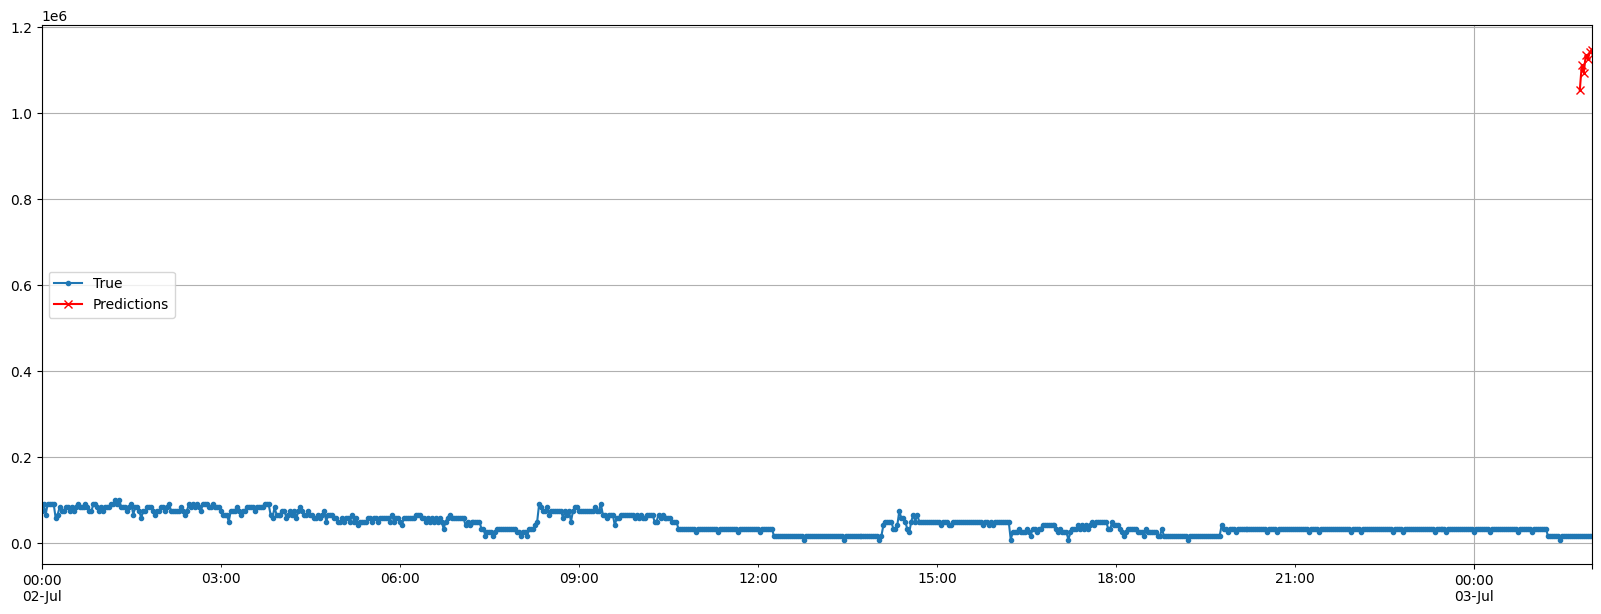

In [98]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2 * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [99]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [100]:
fit_and_evaluate(lstm, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
   3241/Unknown 38s 11ms/step - loss: 0.0952 - mae: 0.2719

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3243/3243 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 0.0952 - mae: 0.2719 - val_loss: 0.0356 - val_mae: 0.1185
Epoch 2/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 79s 12ms/step - loss: 0.0666 - mae: 0.1797 - val_loss: 0.0335 - val_mae: 0.1062
Epoch 3/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0657 - mae: 0.1713 - val_loss: 0.0329 - val_mae: 0.1015
Epoch 4/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0651 - mae: 0.1679 - val_loss: 0.0326 - val_mae: 0.1002
Epoch 5/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0649 - mae: 0.1668 - val_loss: 0.0324 - val_mae: 0.0985
Epoch 6/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0647 - mae: 0.1661 - val_loss: 0.0322 - val_mae: 0.0995
Epoch 7/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0645 - mae: 0.1656 - val_loss: 0.0320 - val_mae: 0.1000
Epoch 8/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - loss: 0.0641 - mae: 0.1649 - val_loss: 0.0319 - val_mae: 0.0981
Epoch 9/10
3243/3243 ━━━━━━━━━━━━━━

98057.24024772644

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


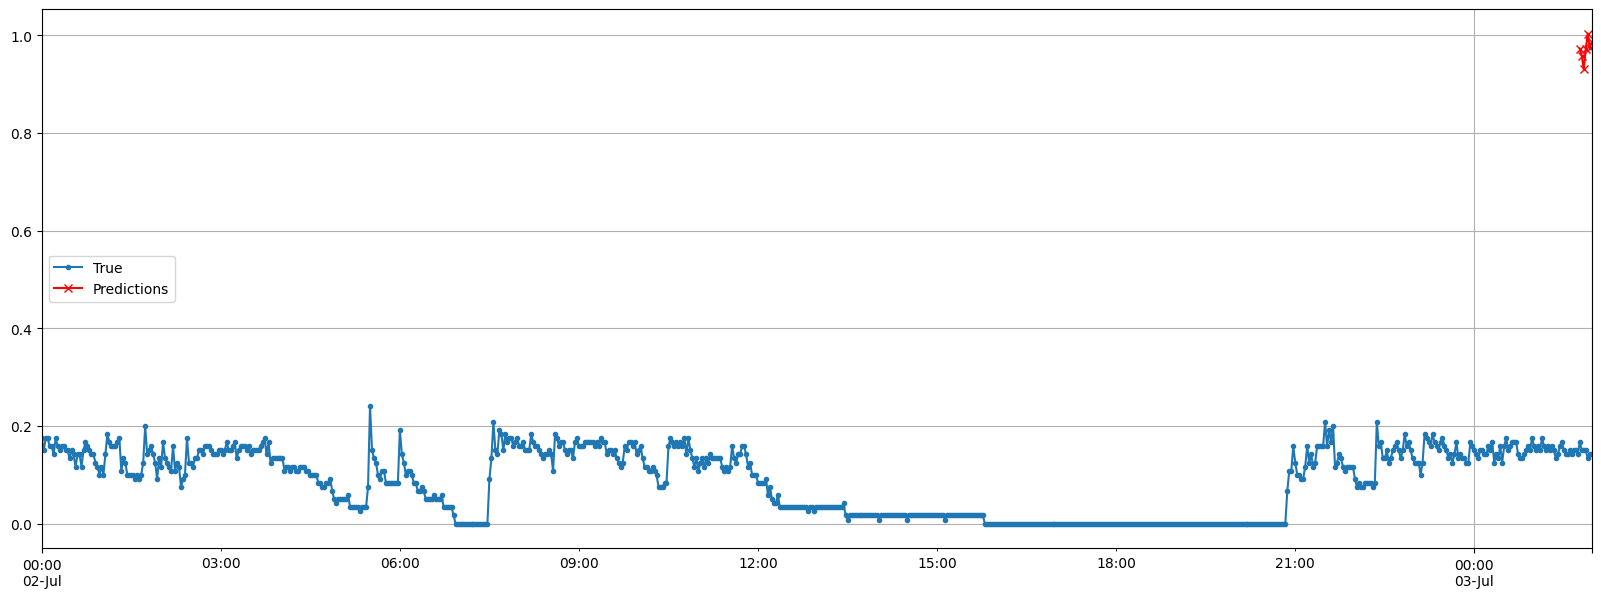

In [101]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [102]:
fit_and_evaluate(lstm, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
   3262/Unknown 39s 12ms/step - loss: 0.0691 - mae: 0.1573

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3268/3268 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0690 - mae: 0.1572 - val_loss: 0.0183 - val_mae: 0.0831
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0668 - mae: 0.1505 - val_loss: 0.0154 - val_mae: 0.0638
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0654 - mae: 0.1484 - val_loss: 0.0144 - val_mae: 0.0555
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 0.0646 - mae: 0.1471 - val_loss: 0.0141 - val_mae: 0.0522
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0641 - mae: 0.1462 - val_loss: 0.0139 - val_mae: 0.0487
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - loss: 0.0636 - mae: 0.1455 - val_loss: 0.0138 - val_mae: 0.0465
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 83s 13ms/step - loss: 0.0634 - mae: 0.1451 - val_loss: 0.0138 - val_mae: 0.0469
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0630 - mae: 0.1442 - val_loss: 0.0138 - val_mae: 0.0463
Epoch 9/10
3268/3268 ━━━━━━━━━━━━━━

45536.41751408577

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


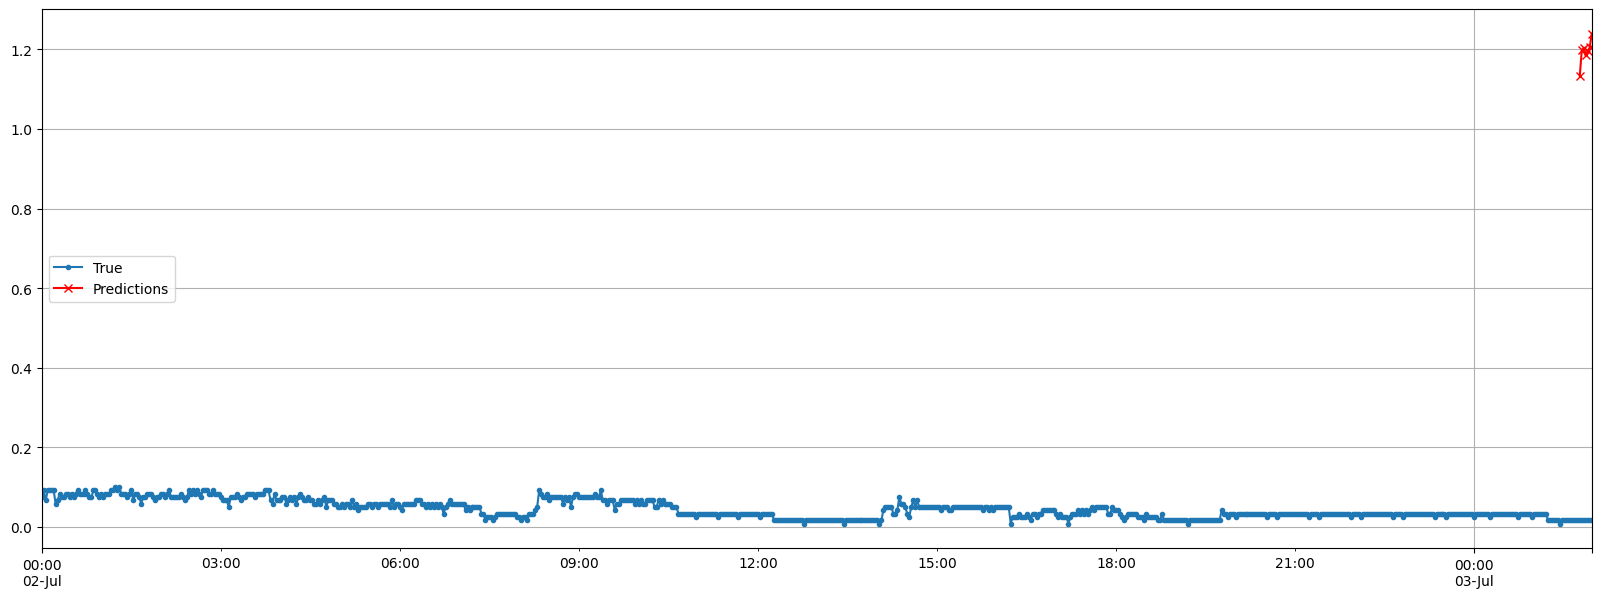

In [103]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [104]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [105]:
fit_and_evaluate(gru, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
   3234/Unknown 45s 13ms/step - loss: 0.0790 - mae: 0.2270

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3243/3243 ━━━━━━━━━━━━━━━━━━━━ 48s 14ms/step - loss: 0.0790 - mae: 0.2269 - val_loss: 0.0330 - val_mae: 0.1040
Epoch 2/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - loss: 0.0659 - mae: 0.1720 - val_loss: 0.0324 - val_mae: 0.0985
Epoch 3/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 0.0656 - mae: 0.1699 - val_loss: 0.0322 - val_mae: 0.0979
Epoch 4/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 43s 13ms/step - loss: 0.0654 - mae: 0.1695 - val_loss: 0.0320 - val_mae: 0.0973
Epoch 5/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - loss: 0.0652 - mae: 0.1692 - val_loss: 0.0319 - val_mae: 0.0965
Epoch 6/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - loss: 0.0651 - mae: 0.1691 - val_loss: 0.0317 - val_mae: 0.0963
Epoch 7/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 0.0649 - mae: 0.1686 - val_loss: 0.0316 - val_mae: 0.0972
Epoch 8/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - loss: 0.0647 - mae: 0.1682 - val_loss: 0.0315 - val_mae: 0.0960
Epoch 9/10
3243/3243 ━━━━━━━━━━━━━━

95970.63064575195

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


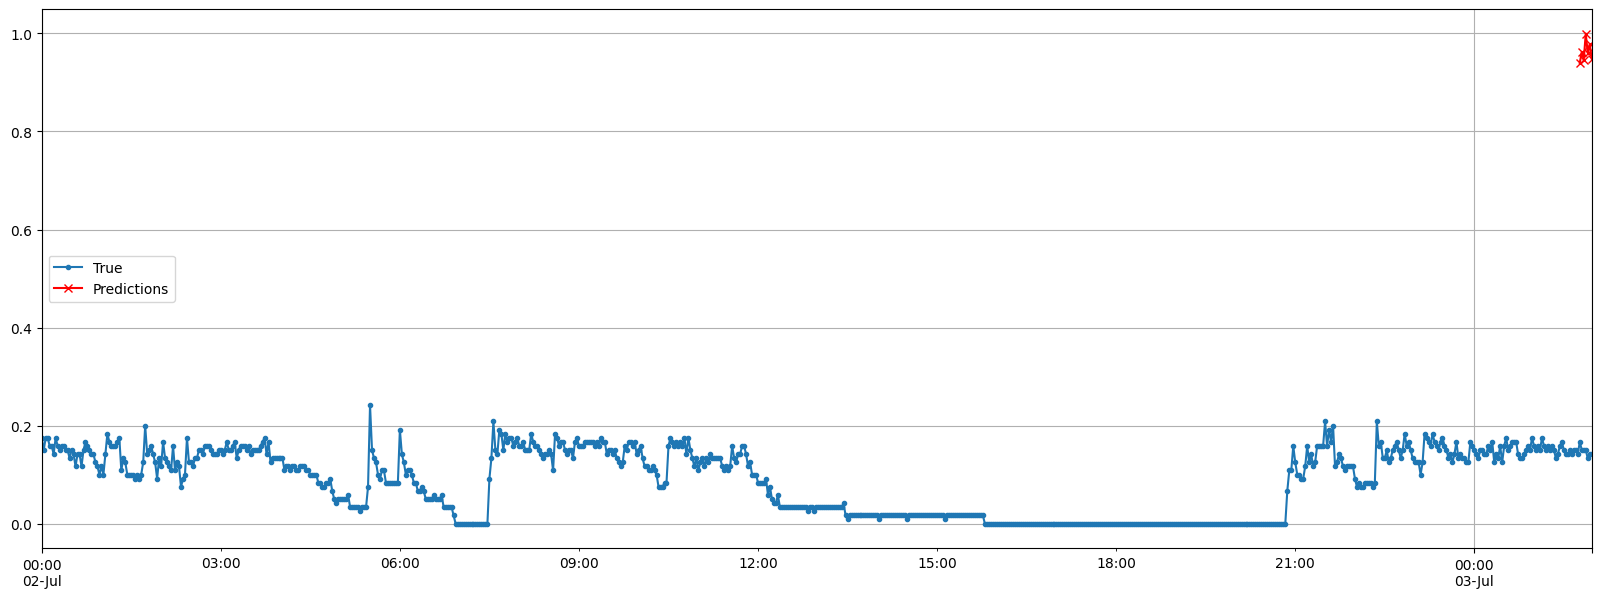

In [106]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [107]:
fit_and_evaluate(gru, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
   3264/Unknown 44s 13ms/step - loss: 0.0697 - mae: 0.1588

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3268/3268 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - loss: 0.0697 - mae: 0.1587 - val_loss: 0.0149 - val_mae: 0.0602
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - loss: 0.0680 - mae: 0.1553 - val_loss: 0.0141 - val_mae: 0.0558
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 0.0673 - mae: 0.1537 - val_loss: 0.0141 - val_mae: 0.0535
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - loss: 0.0670 - mae: 0.1528 - val_loss: 0.0141 - val_mae: 0.0542
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - loss: 0.0665 - mae: 0.1515 - val_loss: 0.0142 - val_mae: 0.0544
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 0.0659 - mae: 0.1504 - val_loss: 0.0143 - val_mae: 0.0550
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 0.0655 - mae: 0.1496 - val_loss: 0.0143 - val_mae: 0.0538
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - loss: 0.0650 - mae: 0.1488 - val_loss: 0.0144 - val_mae: 0.0558
Epoch 9/10
3268/3268 ━━━━━━━━━━━━━━

53507.56645202637

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


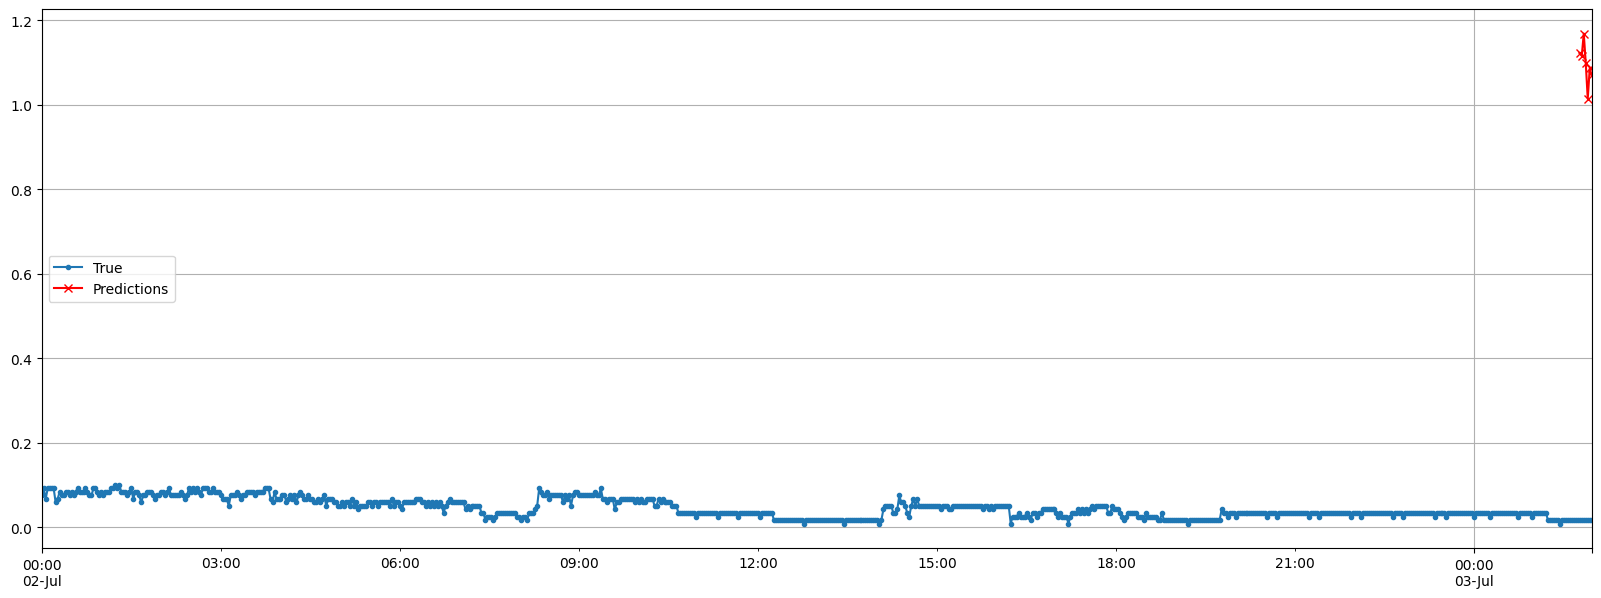

In [108]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [109]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [110]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train1, seq2seq_valid1)

Epoch 1/10
   3236/Unknown 34s 10ms/step - loss: 0.0717 - mae: 0.1941

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3243/3243 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.0716 - mae: 0.1940 - val_loss: 0.0327 - val_mae: 0.1038
Epoch 2/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.0651 - mae: 0.1712 - val_loss: 0.0324 - val_mae: 0.1056
Epoch 3/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0646 - mae: 0.1703 - val_loss: 0.0323 - val_mae: 0.1015
Epoch 4/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0646 - mae: 0.1702 - val_loss: 0.0322 - val_mae: 0.1040
Epoch 5/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0644 - mae: 0.1700 - val_loss: 0.0320 - val_mae: 0.1042
Epoch 6/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0640 - mae: 0.1693 - val_loss: 0.0319 - val_mae: 0.1056
Epoch 7/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0637 - mae: 0.1687 - val_loss: 0.0318 - val_mae: 0.1021
Epoch 8/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0633 - mae: 0.1680 - val_loss: 0.0317 - val_mae: 0.1075
Epoch 9/10
3243/3243 ━━━━━━━━━━━━━━

101475.87209939957

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


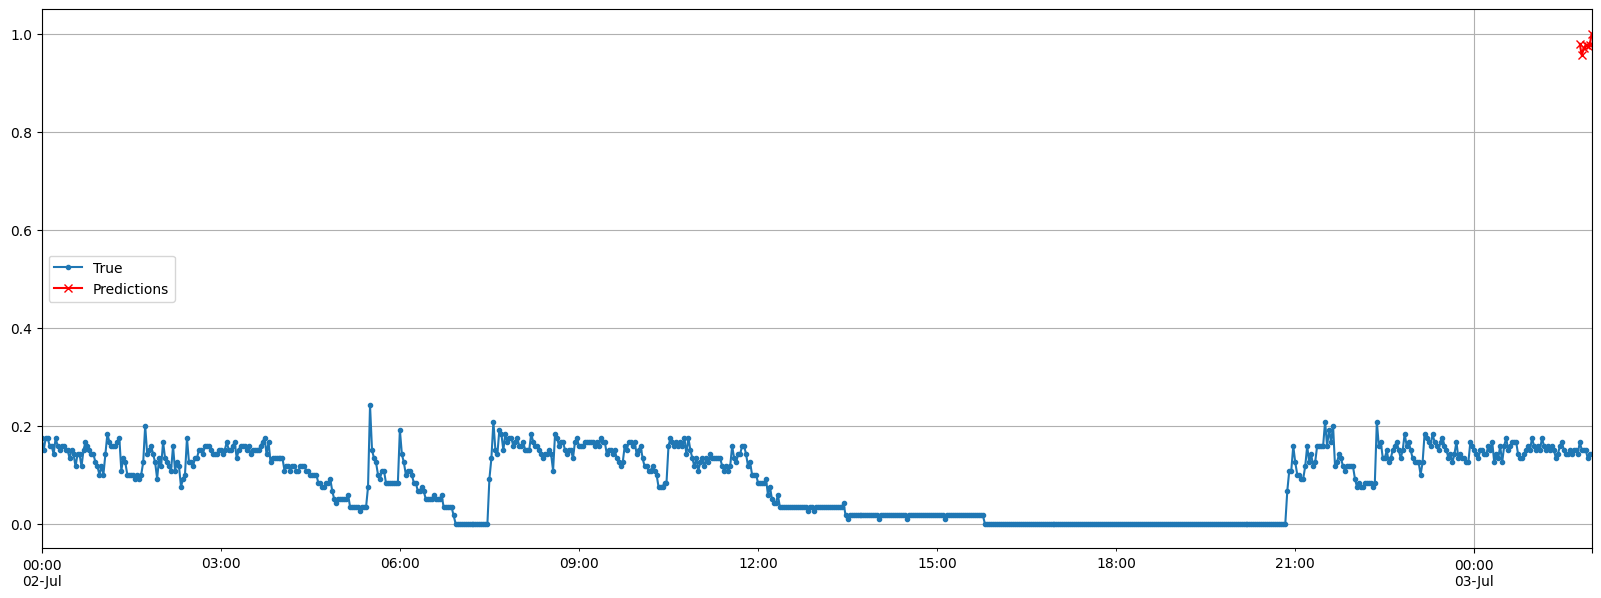

In [111]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [112]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train2, seq2seq_valid2)

Epoch 1/10
   3264/Unknown 35s 10ms/step - loss: 0.0659 - mae: 0.1566

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3268/3268 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0658 - mae: 0.1565 - val_loss: 0.0142 - val_mae: 0.0510
Epoch 2/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.0649 - mae: 0.1529 - val_loss: 0.0140 - val_mae: 0.0489
Epoch 3/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 0.0648 - mae: 0.1529 - val_loss: 0.0139 - val_mae: 0.0449
Epoch 4/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - loss: 0.0646 - mae: 0.1526 - val_loss: 0.0139 - val_mae: 0.0496
Epoch 5/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.0648 - mae: 0.1531 - val_loss: 0.0139 - val_mae: 0.0471
Epoch 6/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - loss: 0.0645 - mae: 0.1526 - val_loss: 0.0138 - val_mae: 0.0472
Epoch 7/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0645 - mae: 0.1520 - val_loss: 0.0139 - val_mae: 0.0485
Epoch 8/10
3268/3268 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.0644 - mae: 0.1515 - val_loss: 0.0138 - val_mae: 0.0452
Epoch 9/10
3268/3268 ━━━━━━━━━━━━━━

44927.582144737244

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


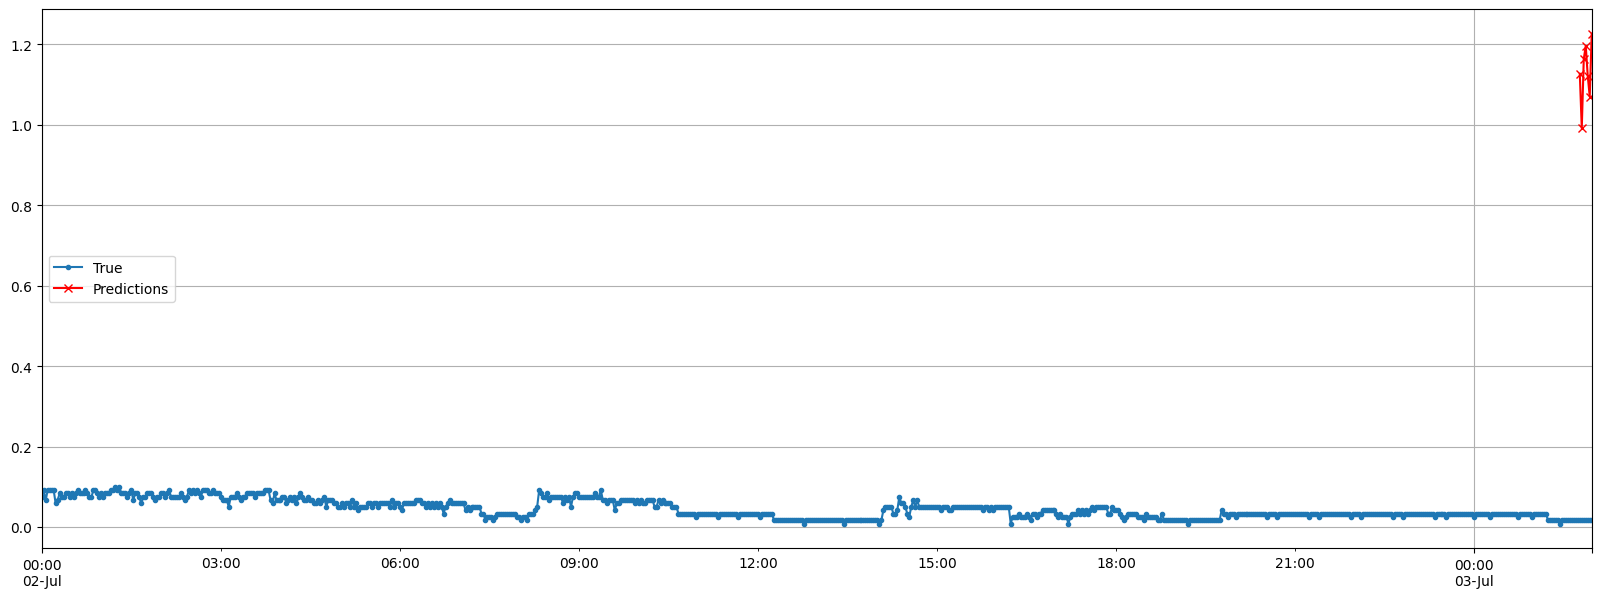

In [113]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [114]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [115]:
# ENDPOINT 1:
longer_train1 = to_seq2seq_dataset(train1, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid1 = to_seq2seq_dataset(valid1, seq_length=sequence_lenght*2)
longer_test1 = to_seq2seq_dataset(test1, seq_length=sequence_lenght*2)
downsampled_train1 = longer_train1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid1 = longer_valid1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test1 = longer_test1.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [116]:
fit_and_evaluate(conv_rnn_model, downsampled_train1, downsampled_valid1)

Epoch 1/10
   3242/Unknown 47s 14ms/step - loss: 0.0840 - mae: 0.2288

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3243/3243 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - loss: 0.0840 - mae: 0.2288 - val_loss: 0.0333 - val_mae: 0.1027
Epoch 2/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 0.0637 - mae: 0.1668 - val_loss: 0.0330 - val_mae: 0.0985
Epoch 3/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 0.0631 - mae: 0.1651 - val_loss: 0.0328 - val_mae: 0.1018
Epoch 4/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 0.0626 - mae: 0.1643 - val_loss: 0.0326 - val_mae: 0.0963
Epoch 5/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - loss: 0.0619 - mae: 0.1633 - val_loss: 0.0322 - val_mae: 0.0942
Epoch 6/10
3243/3243 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - loss: 0.0612 - mae: 0.1619 - val_loss: 0.0320 - val_mae: 0.0949
Epoch 7/10
2795/3243 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0619 - mae: 0.1621

KeyboardInterrupt: 

In [ ]:
X = test1.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts1.index[-sequence_lenght], end=ts1.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts1)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [ ]:
# ENDPOINT 2:
longer_train2 = to_seq2seq_dataset(train2, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid2 = to_seq2seq_dataset(valid2, seq_length=sequence_lenght*2)
longer_test2 = to_seq2seq_dataset(test2, seq_length=sequence_lenght*2)
downsampled_train2 = longer_train2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid2 = longer_valid2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test2 = longer_test2.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [ ]:
fit_and_evaluate(conv_rnn_model, downsampled_train2, downsampled_valid2)

In [ ]:
X = test2.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts2.index[-sequence_lenght], end=ts2.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts2)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [ ]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [ ]:
from statsmodels.tsa.stattools import adfuller

print("Endpoint 1:")
result1 = adfuller(train1['avg_invocations_rate'])
print('ADF Statistic:', result1[0])
print('p-value:', result1[1])
print("Endpoint 2:")
result2 = adfuller(train2['avg_invocations_rate'])
print('ADF Statistic:', result2[0])
print('p-value:', result2[1])

In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train1['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train1['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [ ]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train2['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train2['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [ ]:
trimmed_valid1 = ts1.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid1, order=(1,1,1))
arima = arima.fit()

In [ ]:
# Forecasting
forecast1 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts1.index, ts1, label='Observed')
plt.plot(pd.date_range(trimmed_valid1.index[-1], periods=prediction_lenght, freq=freq), forecast1, label='Forecast', color='red')
plt.axvline(trimmed_valid1.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [ ]:
trimmed_valid2 = ts2.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid2, order=(1,1,1))
arima = arima.fit()

In [ ]:
# Forecasting
forecast2 = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts2.index, ts2, label='Observed')
plt.plot(pd.date_range(trimmed_valid2.index[-1], periods=prediction_lenght, freq=freq), forecast2, label='Forecast', color='red')
plt.axvline(trimmed_valid2.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(forecast1)